<a target="_blank" href="https://colab.research.google.com/github/totti0223/phenogarden/blob/main/modules/001_rice_panicle/main.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Env. Setup

In [15]:
!pip install -qqq onnxruntime-gpu supervision

!git clone -qqq https://github.com/SUNJHZAU/EOPT

fatal: destination path 'EOPT' already exists and is not an empty directory.


# Grain Detection

In [4]:
# check if onnxruntime can use gpu
import subprocess
import onnxruntime as ort

# 利用可能なプロバイダーを取得
available_providers = ort.get_available_providers()

# 物理的な GPU が存在するかチェックする関数
def is_physical_gpu_available():
    try:
        result = subprocess.run(["cuda", "--version"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        return result.returncode == 0
    except FileNotFoundError:
        return False

# GPU が利用可能かをチェック
if 'CUDAExecutionProvider' in available_providers and is_physical_gpu_available():
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
else:
    providers = ['CPUExecutionProvider']

print(f"Selected providers: {providers}")

Selected providers: ['CPUExecutionProvider']


In [5]:
import os
import cv2
import copy
import matplotlib.pyplot as plt
import numpy as np
import supervision as sv

In [7]:
# code based on https://github.com/SUNJHZAU/EOPT
class YOLOv8:
    """
    YOLOv8による物体検出を行うクラス。
    推論と後処理を担当する。
    """

    def __init__(self, onnx_model: str, confidence_thres: float, iou_thres: float,
                 providers=["CUDAExecutionProvider", "CPUExecutionProvider"]):
        """
        YOLOv8のインスタンスを初期化する。

        Args:
            onnx_model (str): ONNXモデルのパス。
            confidence_thres (float): 検出の信頼度しきい値。
            iou_thres (float): NMS（非最大抑制）のIoUしきい値。
        """
        self.onnx_model = onnx_model
        self.confidence_thres = confidence_thres
        self.iou_thres = iou_thres

        # ONNXモデルを用いて推論セッションを作成。CUDAとCPUの両方を利用する。
        self.session = ort.InferenceSession(self.onnx_model,
                                            providers=providers)
        self.model_inputs = self.session.get_inputs()

        # モデルの入力サイズを取得する
        input_shape = self.model_inputs[0].shape
        self.input_width = input_shape[2]
        self.input_height = input_shape[3]

    def preprocess(self, img_path: str) -> np.ndarray:
        """
        画像を推論前に前処理する。

        Args:
            img_path (str): 入力画像のパス。

        Returns:
            np.ndarray: 推論用に前処理された画像データ。
        """
        # OpenCVで画像を読み込み、元画像とそのサイズを保持する
        self.img = cv2.imread(img_path)
        self.img_height, self.img_width = self.img.shape[:2]

        # BGRからRGBに変換し、モデルの入力サイズにリサイズする
        img_rgb = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(img_rgb, (self.input_width, self.input_height))

        # 画像を0～1の範囲に正規化し、チャンネルファーストに変換する
        image_data = np.array(resized_img) / 255.0
        image_data = np.transpose(image_data, (2, 0, 1))
        image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        return image_data

    def postprocess(self, output: list) -> list:
        """
        モデルの出力から検出結果（バウンディングボックス、信頼度、クラスID）を抽出する。

        Args:
            output (list): モデルの推論結果。

        Returns:
            list: 検出結果の辞書リスト。各辞書は 'box', 'score', 'clsID' を含む。
        """
        # 出力を整形する（余分な次元を除去し転置する）
        outputs = np.transpose(np.squeeze(output[0]))
        num_rows = outputs.shape[0]

        boxes, scores, class_ids = [], [], []
        x_scale = self.img_width / self.input_width
        y_scale = self.img_height / self.input_height

        # 各出力行について処理する
        for i in range(num_rows):
            row = outputs[i]
            class_scores = row[4:]
            max_score = np.amax(class_scores)

            # 信頼度が閾値以上の検出のみ採用する
            if max_score >= self.confidence_thres:
                cls_id = int(np.argmax(class_scores))
                x_center, y_center, w, h = row[0], row[1], row[2], row[3]
                left = int((x_center - w / 2) * x_scale)
                top = int((y_center - h / 2) * y_scale)
                right = int((x_center + w / 2) * x_scale)
                bottom = int((y_center + h / 2) * y_scale)
                # width = int(w * x_scale)
                # height = int(h * y_scale)
                #boxes.append([left, top, width, height])
                # record in xyxy format instead
                boxes.append([left,top,right,bottom])
                scores.append(float(max_score))
                class_ids.append(cls_id)

        # 非最大抑制を適用して重複検出を排除する
        indices = cv2.dnn.NMSBoxes(boxes, scores, self.confidence_thres, self.iou_thres)
        results = []

        # NMSBoxesが返す形式に注意（場合によっては [[idx], ...] の形式）
        if len(indices) > 0:
            indices = indices.flatten()  # フラットな配列に変換する
            for idx in indices:
                results.append({
                    'xyxy': boxes[idx],
                    'scores': scores[idx],
                    'class_id': class_ids[idx]
                })

        return results

    def __call__(self, img_path: str) -> list:
        """
        画像パスを与えると、前処理・推論・後処理を実行し検出結果を返す。

        Args:
            img_path (str): 入力画像のパス。

        Returns:
            list: 検出結果の辞書リスト。
        """
        # 前処理、推論、後処理の各工程を順に実施する
        img_data = self.preprocess(img_path)
        outputs = self.session.run(None, {self.model_inputs[0].name: img_data})
        return self.postprocess(outputs)


In [8]:
detector = YOLOv8('GrainNuber.onnx', 0.1, 0.8, providers=providers)

In [9]:
path = "/content/EOPT/show/cut/1269.jpg"
result = detector(path)

In [10]:
def from_yolov8(cls, result):
    """
    Creates a Detections instance from yolov8. monkey patch for supervision.
    """
    return cls(
        xyxy=np.array([x["xyxy"] for x in result]),
        confidence=np.array([x["scores"] for x in result]),
        class_id=np.array([x["class_id"] for x in result]),
        tracker_id=None,
        data={"class_name": np.array(["grain"]*len(result))}
    )
sv.Detections.from_yolov8 = classmethod(from_yolov8)

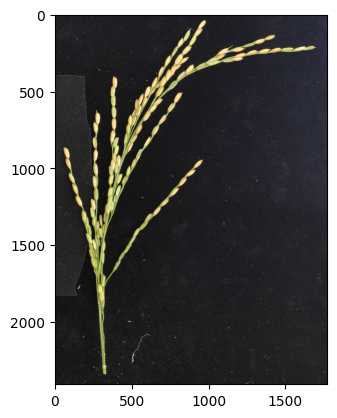

In [11]:
image = cv2.imread(path)
plt.imshow(image[...,::-1])

In [12]:
result = detector(path)

orig_detections = sv.Detections.from_yolov8(result)

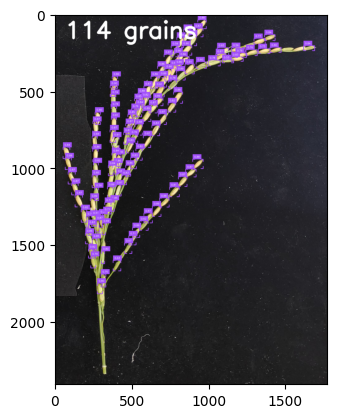

In [13]:
detections = copy.deepcopy(orig_detections[orig_detections.confidence>0.5])

# bounding_box_annotator = sv.BoxAnnotator()
bounding_box_annotator = sv.BoxCornerAnnotator()#sv.RoundBoxAnnotator()
label_annotator = sv.LabelAnnotator(
    text_scale=0.5
)

labels = [
    f"{confidence:.2f}"
    for confidence
    in detections.confidence
]

annotated_image = bounding_box_annotator.annotate(
    scene=image.copy(),
    detections=detections,
)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels)

annotated_image = sv.draw_text(
    scene=annotated_image, text=str(len(detections.xyxy))+" grains",
    text_anchor=sv.Point(x=500,y=100),
    text_color=sv.Color(255,255,255),
    text_scale=5,
    text_thickness=15)
# plt.axis("off")
plt.imshow(annotated_image[...,::-1])

# Grain Length Width

depends on Grain Detection result variable "detections"

In [ ]:
import cv2
import numpy as np
import pandas as pd

In [ ]:
import cv2
import numpy as np
import pandas as pd

def analyze_kernels(image, uncut_image, bboxes, real_radius_mm=25):
    """
    Analyze kernels from an image and extract length, width, and aspect ratio.

    :param image: OpenCV image containing kernels.
    :param uncut_image: OpenCV image containing a reference object.
    :param bboxes: NumPy array of shape (N, 4) containing bounding boxes as [xmin, ymin, xmax, ymax].
    :param real_radius_mm: Real-world size of the reference circle in mm (default: 25mm).
    :return: Tuple (annotated image, DataFrame with length, width, aspect ratio, and pixels per mm).
    """
    if not isinstance(bboxes, np.ndarray) or bboxes.shape[1] != 4:
        raise ValueError("Bounding boxes must be a NumPy array with shape (N, 4).")

    # Convert uncut image to RGB and detect reference circle (red)
    image_rgb = cv2.cvtColor(uncut_image, cv2.COLOR_BGR2RGB)
    lower_red, upper_red = np.array([105, 0, 15]), np.array([255, 100, 255])
    mask = cv2.inRange(image_rgb, lower_red, upper_red)

    # Morphological processing to clean the mask
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Detect reference object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pixels_per_mm = None
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        (_, _), radius = cv2.minEnclosingCircle(max_contour)
        pixels_per_mm = real_radius_mm / radius  # Calculate pixel-to-mm ratio

    # Process each bounding box
    kernel_data = []
    annotated_image = image.copy()

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox.astype(int)

        # Expand bounding box slightly
        xmin, ymin = max(0, xmin - 15), max(0, ymin - 15)
        xmax, ymax = min(image.shape[1], xmax + 15), min(image.shape[0], ymax + 15)

        # Crop kernel region
        kernel_crop = image[ymin:ymax, xmin:xmax]

        # Apply RGB thresholding for segmentation
        lower_rgb, upper_rgb = (26, 109, 159), (134, 189, 214)
        mask = cv2.inRange(kernel_crop, lower_rgb, upper_rgb)

        # Find contours (detecting kernel shape)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        max_contour = max(contours, key=cv2.contourArea)

        # Get the minimum enclosing rectangle
        rect = cv2.minAreaRect(max_contour)
        w, h = rect[1]
        aspect_ratio = max(w, h) / min(w, h)

        # Convert to real-world measurements
        real_length = real_width = None
        if pixels_per_mm:
            real_length = max(w, h) * pixels_per_mm
            real_width = min(w, h) * pixels_per_mm

        # Append to results
        kernel_data.append([real_length, real_width, aspect_ratio, pixels_per_mm])

        # Get the rotated rectangle's corner points
        box = cv2.boxPoints(rect).astype(int)

        # Offset the box points to match the original image coordinates
        box[:, 0] += xmin
        box[:, 1] += ymin

        # Draw rotated rectangle on the annotated image
        cv2.drawContours(annotated_image, [box], 0, (0, 255, 0), 2)

        # Draw bounding box (blue) on the annotated image
        cv2.rectangle(annotated_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    # Convert results to DataFrame
    df = pd.DataFrame(kernel_data, columns=['Length (mm)', 'Width (mm)', 'Aspect Ratio', 'Pixels/mm'])

    return annotated_image, df

In [ ]:
image = cv2.imread("/content/EOPT/show/cut/1269.jpg")
uncut = cv2.imread("/content/EOPT/show/raw/1269.jpg")

annotated_image, df = analyze_kernels(image, uncut, detections.xyxy, real_radius_mm=25)

In [ ]:
df

,Length (mm),Width (mm),Aspect Ratio,Pixels/mm
0,2.285554,0.972576,2.350000,0.100251
1,8.453511,2.964763,2.851327,0.100251
2,10.040408,4.795419,2.093750,0.100251
3,4.282602,0.652333,6.565056,0.100251
4,9.640774,3.686178,2.615385,0.100251
...,...,...,...,...
109,7.749924,1.187888,6.524122,0.100251
110,4.310786,0.501254,8.600000,0.100251
111,6.124728,1.247630,4.909091,0.100251
112,10.375731,1.952810,5.313231,0.100251


In [ ]:
# prompt: use plotly to visualize Length (mm)	Width (mm) 	Aspect Ratio of df with histogram

import pandas as pd
import plotly.express as px

fig = px.scatter(df, x="Length (mm)", y="Width (mm)", color="Aspect Ratio",
                 title="Length vs. Width of Grains, Colored by Aspect Ratio",
                 labels={"Length (mm)": "Length (mm)", "Width (mm)": "Width (mm)", "Aspect Ratio": "Aspect Ratio"})
fig.show()


fig = px.histogram(df, x="Length (mm)", nbins=10, title='Histogram of Length (mm)')
fig.show()

fig = px.histogram(df, x="Width (mm)", nbins=10, title='Histogram of Width (mm)')
fig.show()

fig = px.histogram(df, x="Aspect Ratio", nbins=10, title='Histogram of Aspect Ratio')
fig.show()


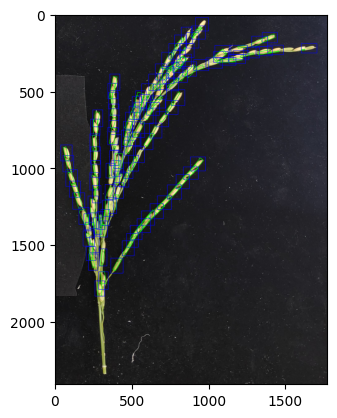

In [ ]:
plt.imshow(annotated_image[...,::-1])

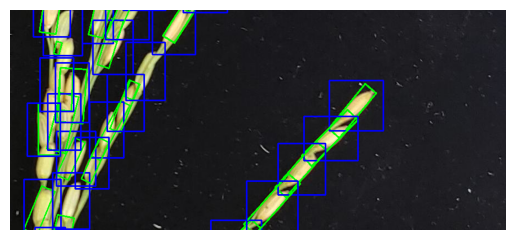

In [ ]:
plt.axis("off")
plt.imshow(annotated_image[...,::-1][800:1200,300:1200,:])

# Panicle Length

In [16]:
import cv2
import heapq
import numpy as np
import pandas as pd
from skimage.morphology import skeletonize

In [47]:
import cv2
import heapq
import numpy as np
import pandas as pd
from skimage.morphology import skeletonize

def analyze_panicle_length(image, uncut_image, real_radius_mm=25):
    """
    骨格抽出とA*探索を用いて穂長を計測する独立関数である。
    入力画像（image）と基準オブジェクトを含む画像（uncut_image）から、
    端点集合の中で一番下の点を start とし、start より上にある端点の中から
    A*経路長が最大のものを end として経路を探索する。
    また、基準オブジェクトからピクセル→mm変換比率を算出する。

    :param image: 穂画像。前処理済みのOpenCV画像（BGR形式）。
    :param uncut_image: 基準オブジェクト（赤色円）を含むOpenCV画像（BGR形式）。
    :param real_radius_mm: 基準となる赤色実心円の実際の半径（単位：mm）。初期値は25。
    :return: (annotated_image, df)
             annotated_image: 穂の主経路が描画された画像。
             df: 穂長および変換比率を含む DataFrame。
    """
    # 赤色基準オブジェクトの検出（RGB変換してマスク作成）
    image_rgb = cv2.cvtColor(uncut_image, cv2.COLOR_BGR2RGB)
    lower_red, upper_red = np.array([105, 0, 15]), np.array([255, 100, 255])
    mask_red = cv2.inRange(image_rgb, lower_red, upper_red)
    kernel = np.ones((7, 7), np.uint8)
    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pixels_per_mm = None
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        (_, _), radius = cv2.minEnclosingCircle(max_contour)
        pixels_per_mm = real_radius_mm / radius  # ピクセル→mm変換比率を算出

    # 穂領域の前処理（HSV変換→Sチャンネル抽出→大津の二値化）
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    _, _, s_channel = cv2.split(hsv)
    _, thresh = cv2.threshold(s_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 小領域の除去（面積が一定未満の領域を削除）
    area_threshold = 37000
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in cnts:
        if cv2.contourArea(cnt) < area_threshold:
            cv2.drawContours(thresh, [cnt], -1, 0, -1)

    # 小さな穴の充填（穴の面積が閾値未満なら塗りつぶす）
    hole_area_threshold = 1000
    cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if hierarchy is not None:
        for i in range(len(cnts)):
            if hierarchy[0][i][3] != -1 and cv2.contourArea(cnts[i]) < hole_area_threshold:
                cv2.drawContours(thresh, [cnts[i]], 0, 255, -1)

    # 骨格抽出
    skeleton = skeletonize(thresh)
    skeleton = (skeleton.astype(np.uint8)) * 255

    # 骨格上の全点抽出
    points = list(zip(*np.where(skeleton == 255)))
    if not points:
        print("no skeleton detected")
        return image, pd.DataFrame()

    # 端点抽出：中心以外の非ゼロ画素が1個だけなら端点とする
    end_points = []
    for pt in points:
        y, x = pt
        region = skeleton[max(0, y-1):y+2, max(0, x-1):x+2]
        neighbor_count = np.count_nonzero(region) - 1
        if neighbor_count == 1:
            end_points.append(pt)
    if not end_points:
        print("no end points")
        return image, pd.DataFrame()

    # 一番下の端点を start とする
    start_point = max(end_points, key=lambda p: p[0])
    # start より上にある端点を候補とする（ただし start 自体は除く）
    candidate_end_points = [pt for pt in end_points if pt != start_point and pt[0] < start_point[0]]
    if not candidate_end_points:
        # 候補がなければ start 以外の端点全てを対象とする
        candidate_end_points = [pt for pt in end_points if pt != start_point]

    # set に変換して A* の探索を高速化
    skeleton_points = set(points)
    def astar(start, goal):
        frontier = [(0, start)]
        came_from = {}
        cost_so_far = {start: 0}
        while frontier:
            _, current = heapq.heappop(frontier)
            if current == goal:
                break
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    if dy == 0 and dx == 0:
                        continue
                    neighbor = (current[0] + dy, current[1] + dx)
                    if neighbor not in skeleton_points:
                        continue
                    new_cost = cost_so_far[current] + 1
                    if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                        cost_so_far[neighbor] = new_cost
                        priority = new_cost + abs(neighbor[0] - goal[0]) + abs(neighbor[1] - goal[1])
                        heapq.heappush(frontier, (priority, neighbor))
                        came_from[neighbor] = current
        path = []
        current = goal
        while current != start:
            path.append(current)
            if current not in came_from:
                return None
            current = came_from[current]
        path.append(start)
        return path[::-1]

    best_path = None
    max_length = 0
    best_candidate = None
    # 各候補について A* 経路を計算し、最も長い経路を end として採用する
    for candidate in candidate_end_points:
        path = astar(start_point, candidate)
        if path and len(path) > max_length:
            max_length = len(path)
            best_path = path
            best_candidate = candidate

    if best_path is None:
        return image, pd.DataFrame()

    # 経路長を実寸に換算
    real_length = max_length * pixels_per_mm

    # 経路描画：緑色の小円で経路を表示
    annotated_image = image.copy()
    for pt in best_path:
        cv2.circle(annotated_image, (pt[1], pt[0]), 3, (0, 255, 0), -1)

    # 結果をDataFrameにまとめる
    df = pd.DataFrame([[real_length, pixels_per_mm]], columns=['Panicle Length (mm)', 'Pixels/mm'])

    return annotated_image, df


In [48]:
image = cv2.imread("/content/EOPT/show/cut/1269.jpg")
uncut = cv2.imread("/content/EOPT/show/raw/1269.jpg")

annotated_image,df = analyze_panicle_length(image, uncut)

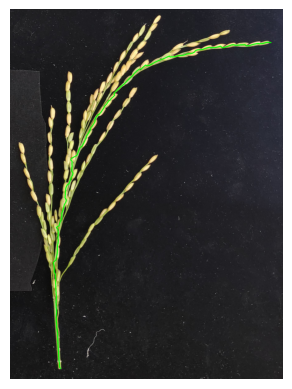

In [49]:
plt.axis("off")
plt.imshow(annotated_image[...,::-1])